In [1]:
import os
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

Known Land Cover types were derived from classified objects built in eCognition. An accuracy assessment of these classes held 90+% accuracy of each land cover type. 

Land Cover Types
- Buildings
- Pavement
- Trees
- Healthy Grass

Each class contained upwards of 800k objects with the following spectral metrics. These metrics will be the features used to train the neural network.
- Mean Red: Mean Red value of object
- Mean Green: Mean Green value of object
- Mean Blue: Mean Blue value of object
- Mean NIR: Mean Near-infrared of object
- Mean nDSM: Mean elevation of object
- NDVI: Vegation Indice (Mean NIR - Mean Red) / (Mean NIR + Mean Red) (i.e. proxy for impervious/pervious surfaces)
- Std. DSM: Standard deviation of elevation in object (i.e. proxy for smoothness)

For speed purposes, I have only selected 4000 records from each class. These records will be combined in a single dataframe and then used to train and test the neural network.

In [2]:
all_df = pd.DataFrame()
for fi in glob.glob('Inputs/*.shp'):    
    df = gpd.read_file(os.path.abspath(fi))
    sample = df.loc[:, ['Land_Truth', 
                        'Mean_Red', 
                        'Mean_Green', 
                        'Mean_Blue', 
                        'Mean_NIR', 
                        'Mean_nDSM', 
                        'NDVI', 
                        'sd_dsm']].sample(4000)
    
    all_df = pd.concat([all_df, sample])
    print(fi)

# shuffle dataframe
all_df = all_df.sample(frac=1).reset_index(drop=True)
all_df.head()

Inputs\Buildings.shp
Inputs\HealthyGrass.shp
Inputs\Pavement.shp
Inputs\Trees.shp


,Land_Truth,Mean_Red,Mean_Green,Mean_Blue,Mean_NIR,Mean_nDSM,NDVI,sd_dsm
0,Buildings,141.740741,144.222222,153.851852,80.629630,7.248476,-0.274817,3.596158
1,Trees,55.800000,74.500000,63.033333,168.333333,4.697876,0.502082,2.221059
2,Pavement,148.352941,145.411765,136.470588,108.529412,1.601957,-0.155026,1.158131
3,Healthy Grass,92.062500,103.468750,83.812500,150.843750,0.529682,0.241992,0.799021
4,Pavement,195.500000,190.000000,186.625000,152.750000,0.027512,-0.122757,0.021013


## Exploratory Data Analysis
The following creates a few figures to highlight some of the main distinctions between impervious and pervious surfaces. This distinction is very important when combined with the Mean nDSM attribute which can then further delineate each class. 

Text(0.5, 1.0, 'NDVI by Class')

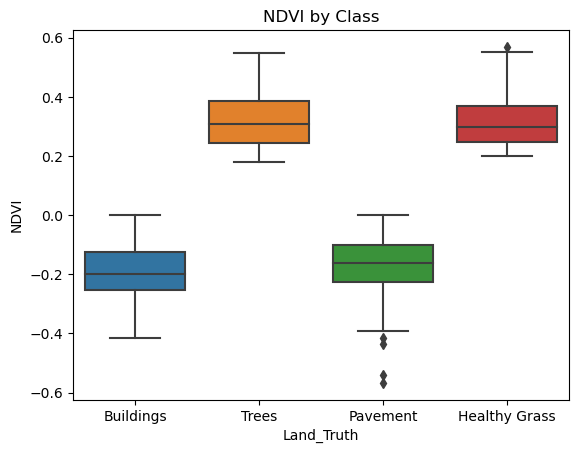

In [4]:
sns.boxplot(data=all_df, x='Land_Truth', y='NDVI')
plt.title('NDVI by Class')


Text(0.5, 1.0, 'Height by Class')

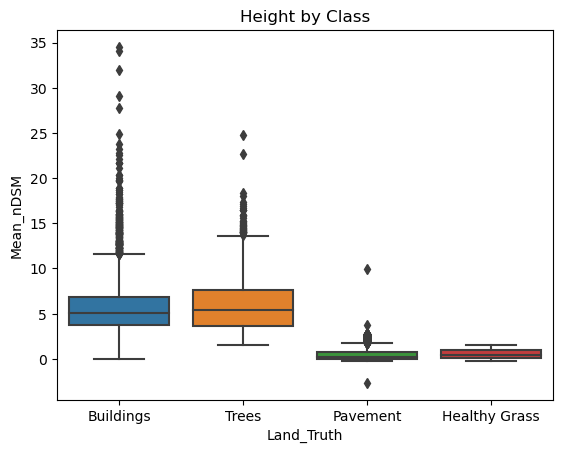

In [5]:
sns.boxplot(data=all_df, x='Land_Truth', y='Mean_nDSM')
plt.title('Height by Class')

## Clean Data
Based on the above figures we see a few distinctions. First off, both impervious classes (buildings, pavement) have low NDVI values, whereas pervious(grass, trees) have high NDVI values. This makes sense as vegetation reflect more NIR whereas man-made structures reflect more Red. 

Secondly, height (elevation) for each class intutively makes sense: Buildings and Trees are much taller, whereas Pavement and Healthy Grass have values at or around 0-meters. Buildings primarily consist of heights around 5 to 7 meter with a large collection of outliers ranging upward of 40-meters. This makes sense as much of the imagery consist of residental neighborhoods with regular sized homes (5-7 meters or 15-20 feet), and a small downtown area containing much taller buildings. 

It's important to note that the Pavement class has a small colleciton of outliers with heights around 5-meters. This may be incorrect values and something that could be removed to give a better represenation of the class. These particular outliers could be objects that were not segmented quite well and could contain a mixture of other classes. 

### Identify the relatively high nDSM values in the Pavement class

From a look of the distribution of the Mean_nDSM metric, we can see that the marjority of the values (75%) are within 0.73 meters. To find the group of outliers we can use the traditional definition of an outlier which is IQR * 1.5. Since are outliers are all high, then the calculation would be Q3 + IQR*1.5

In [4]:
pavement_stats = all_df[all_df['Land_Truth'] == 'Pavement'].describe(percentiles=[.25,.5,.75,.9]).T
pavement_stats

,count,mean,std,min,25%,50%,75%,90%,max
Mean_Red,4000.0,149.895606,26.835801,56.277487,127.895833,151.491383,171.768113,185.099645,217.166667
Mean_Green,4000.0,145.283050,26.775062,54.250000,124.266137,145.600000,166.046586,181.366857,218.833333
Mean_Blue,4000.0,138.732670,26.317025,59.500000,119.377674,136.717618,156.755896,175.943750,221.166667
Mean_NIR,4000.0,109.340559,30.014681,33.904762,85.426692,107.000000,132.595238,151.969494,210.365854
Mean_nDSM,4000.0,0.532636,0.736159,-2.645690,0.031070,0.191374,0.713001,1.798285,9.905356
NDVI,4000.0,-0.166306,0.078090,-0.567107,-0.226390,-0.161243,-0.100604,-0.071942,-0.000387
sd_dsm,4000.0,0.683168,0.759618,0.000000,0.068042,0.428231,1.052375,1.771596,9.344269


In [7]:
PAVEMENT_Q3 = pavement_stats.loc['Mean_nDSM', '75%']
PAVEMENT_Q1 = pavement_stats.loc['Mean_nDSM', '25%']	
OUTLIER_PAVEMENT = PAVEMENT_Q3 + ((PAVEMENT_Q3 - PAVEMENT_Q1)*1.5)

# locate outliers
pavement_outlier = all_df[(all_df['Land_Truth'] == 'Pavement') & 
       (all_df['Mean_nDSM'] >= (OUTLIER_PAVEMENT))]

print(pavement_outlier['Mean_nDSM'].describe().T)

count    426.000000
mean       2.262726
std        0.485944
min        1.731592
25%        1.990124
50%        2.193676
75%        2.513737
max        9.905356
Name: Mean_nDSM, dtype: float64


Text(0.5, 1.0, 'Height Distribution of Pavement Outliers')

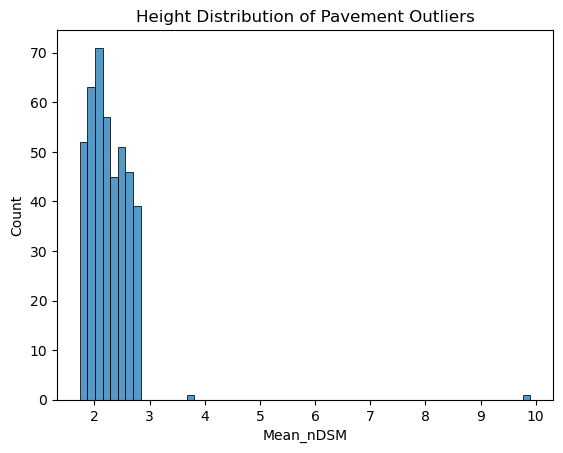

In [8]:
# histogram to show distribution of the Pavement Outliers
sns.histplot(pavement_outlier['Mean_nDSM'])
plt.title('Height Distribution of Pavement Outliers')

It is important to ensure each labelled class has clear and distinct characteristics. Since the whole thing clearly differentating Pavement from the Buildings class is the Mean_nDSM attribute it is important to ensure values do not overlap from each class.

The next step will be to look at the low end of heights in the Buildings Mean_nDSM distribution and identify a threshold to use for the Pavement class. Conversely, Buildings that overlap in height (i.e. within 2 std (75%)) should be removed. 

I have chosen to drop these outliers. In some cases, it may be smarter to reclassify these objects. 

In [9]:
all_df[all_df['Land_Truth'] == 'Buildings'].describe().T


,count,mean,std,min,25%,50%,75%,max
Mean_Red,4000.0,148.525485,29.602629,100.038462,124.633871,145.180707,171.203922,225.816667
Mean_Green,4000.0,144.609455,30.532259,73.142857,120.186458,140.832633,166.677296,227.966667
Mean_Blue,4000.0,139.747364,33.017933,71.000000,114.640706,133.870894,161.595732,229.300000
Mean_NIR,4000.0,104.831242,34.895306,43.515152,78.114551,96.894444,125.601786,211.771429
Mean_nDSM,4000.0,5.884369,3.097025,0.007741,3.797056,5.084790,6.899688,34.528684
NDVI,4000.0,-0.186320,0.085194,-0.414865,-0.252791,-0.198344,-0.124202,-0.000368
sd_dsm,4000.0,1.461108,1.147656,0.003447,0.621956,1.201917,1.972822,13.783238


In [10]:
PAVEMENT_90PERCENTILE = pavement_stats.loc['Mean_nDSM', '90%']

bad_pavement = all_df[(all_df['Land_Truth'] == 'Pavement') &
       (all_df['Mean_nDSM'] >= OUTLIER_PAVEMENT)]


bad_buildings = all_df[(all_df['Land_Truth'] == 'Buildings') &
       (all_df['Mean_nDSM'] <= PAVEMENT_90PERCENTILE)]

all_bad = pd.concat([bad_pavement, bad_buildings])
all_df_clean = all_df.drop(all_bad.index)

Text(0.5, 1.0, 'Height by Class')

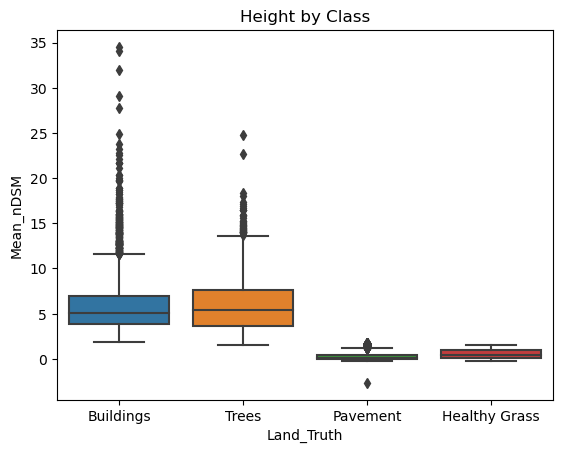

In [11]:
sns.boxplot(data=all_df_clean, x='Land_Truth', y='Mean_nDSM')
plt.title('Height by Class')

The figure above, shows a better delineation of each class after removing some of the outliers in the Pavement class and reducing the lower-Quartile of the Buildings class to ensure minimal overlap. 

## Model Development
Deep Neural Network using a rectified linear unit for the activation funciton. This will be a mutually exclusive multi-classification model. For this, labels need to be converted to dummy variables. 

### - Healthy Grass = 0
### - Trees = 1
### - Pavement = 2
### - Buildings = 3

In [12]:
# convert labels (Land Truth to integers)
def convert_labels(x):
    if x == 'Healthy Grass':
        return 0
    elif x == 'Trees':
        return 1
    elif x == 'Pavement':
        return 2
    else:
        return 3 # Buildings

all_df_clean['Class'] = all_df_clean['Land_Truth'].apply(lambda x: convert_labels(x))
all_df_clean = all_df_clean.drop('Land_Truth', axis=1)
all_df_clean.head(1)

,Mean_Red,Mean_Green,Mean_Blue,Mean_NIR,Mean_nDSM,NDVI,sd_dsm,Class
0,141.740741,144.222222,153.851852,80.62963,7.248476,-0.274817,3.596158,3


In [13]:
from sklearn.model_selection import train_test_split

Features have been split at a 70/30 ratio
- 70% for Training
- 30% for Testing

In [14]:
X = all_df_clean.drop('Class',axis=1).values # features
y = all_df_clean['Class'].values # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

### Normalize Data
Normalizing is required if features are of different units. Here I have used a basic MinMax which transforms each value between 0 and 1, while perserving the intra-relationship (ratios) of features.

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) # only fit to traning data!
X_test = scaler.transform(X_test) # transform 

### Create and compile model
The model's first layer has 7 neurons since there are 7 features. For simplicity's sake I've only included one hidden layer that contains about half the nuerons in the first layer. The last layer uses a softmax function since this is a multi-classificaiton model. 


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [22]:
model = Sequential()

# input layer
model.add(Dense(8,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(4,activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

### Train Model

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [25]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=150,
          batch_size=100,
          validation_data=(X_test, y_test), 
          verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/150
109/109 [==============================] - 1s 7ms/step - loss: 1.3689 - val_loss: 1.3148
Epoch 2/150
109/109 [==============================] - 0s 4ms/step - loss: 1.2308 - val_loss: 1.0727
Epoch 3/150
109/109 [==============================] - 0s 4ms/step - loss: 1.0303 - val_loss: 0.8882
Epoch 4/150
109/109 [==============================] - 0s 3ms/step - loss: 0.9202 - val_loss: 0.7781
Epoch 5/150
109/109 [==============================] - 0s 3ms/step - loss: 0.8487 - val_loss: 0.7337
Epoch 6/150
109/109 [==============================] - 0s 3ms/step - loss: 0.8105 - val_loss: 0.7141
Epoch 7/150
109/109 [==============================] - 0s 3ms/step - loss: 0.7911 - val_loss: 0.7018
Epoch 8/150
109/109 [==============================] - 0s 3ms/step - loss: 0.7709 - val_loss: 0.6939
Epoch 9/150
109/109 [==============================] - 0s 3ms/step - loss: 0.7637 - val_loss: 0.6887
Epoch 10/150
109/109 [==============================] - 0s 2ms/step - loss: 0.7584 - val_lo

### Evaluate Model 

<AxesSubplot: >

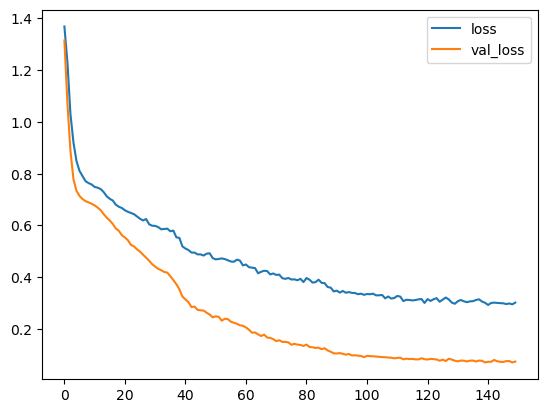

In [26]:
# Learning Rate
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

### Predictions on test

In [28]:
predictions = model.predict(X_test)

146/146 [==============================] - 0s 1ms/step


In [29]:
predictions = np.argmax(predictions, axis=1)

In [30]:
from sklearn.metrics import classification_report,confusion_matrix

In [31]:
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions))

Confusion Matrix
[[1202    0    0    0]
 [  53 1146    0    0]
 [   0    0 1079    0]
 [   0    0    3 1182]]


In [32]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1202
           1       1.00      0.96      0.98      1199
           2       1.00      1.00      1.00      1079
           3       1.00      1.00      1.00      1185

    accuracy                           0.99      4665
   macro avg       0.99      0.99      0.99      4665
weighted avg       0.99      0.99      0.99      4665



In [33]:
# test model on a new input
sample = all_df.sample(1)
sample

,Land_Truth,Mean_Red,Mean_Green,Mean_Blue,Mean_NIR,Mean_nDSM,NDVI,sd_dsm
14896,Buildings,153.322581,152.548387,160.322581,90.193548,4.501323,-0.25924,6.232467


In [34]:
sample_prediction = model.predict(sample.drop(['Land_Truth'], axis=1))
sample_prediction = np.argmax(sample_prediction, axis=1)
sample_prediction

1/1 [==============================] - 0s 71ms/step


array([3], dtype=int64)

In [35]:
# Save model for later use
with open('obia_ml_tensor1.pkl', 'wb') as f:
    pickle.dump(model, f)